In [58]:
%matplotlib inline
import h5pyd
import requests
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from scipy.interpolate import interp1d

In [59]:
# Open the desired year of nsrdb data
DATA_YEAR = "2016"
DATA_MONTH = "06"
nsrdb_year = h5pyd.File(f"/nrel/nsrdb/v3/nsrdb_{DATA_YEAR}.h5", 'r')

## NSRBD Data for Month
After this cell `time_series` is a pandas `DateTimeIndex` localized to LA.

In [60]:
SITE_IDX = 131123 # closest NSRDB site to Fort Ross (used KD tree from demo)
SITE_TIMEZONE = 'America/Los_Angeles'

# pull the full year of ghi data for this site from NSRDB
site_ghi_series = nsrdb_year['ghi'][:, SITE_IDX]

# also pull the timestamps for the ghi data series, then localize them from UTC
time_series_naive = pd.to_datetime(nsrdb_year['time_index'][...].astype(str))
time_series = time_series_naive.tz_localize('UTC').tz_convert(SITE_TIMEZONE)
time_series

DatetimeIndex(['2015-12-31 16:00:00-08:00', '2015-12-31 16:30:00-08:00',
               '2015-12-31 17:00:00-08:00', '2015-12-31 17:30:00-08:00',
               '2015-12-31 18:00:00-08:00', '2015-12-31 18:30:00-08:00',
               '2015-12-31 19:00:00-08:00', '2015-12-31 19:30:00-08:00',
               '2015-12-31 20:00:00-08:00', '2015-12-31 20:30:00-08:00',
               ...
               '2016-12-31 11:00:00-08:00', '2016-12-31 11:30:00-08:00',
               '2016-12-31 12:00:00-08:00', '2016-12-31 12:30:00-08:00',
               '2016-12-31 13:00:00-08:00', '2016-12-31 13:30:00-08:00',
               '2016-12-31 14:00:00-08:00', '2016-12-31 14:30:00-08:00',
               '2016-12-31 15:00:00-08:00', '2016-12-31 15:30:00-08:00'],
              dtype='datetime64[ns, America/Los_Angeles]', length=17568, freq=None)

In [61]:
# get start and end of selected month
start_of_month = pd.to_datetime(f"{DATA_YEAR}-{DATA_MONTH}-01").tz_localize(SITE_TIMEZONE)
end_of_month = start_of_month + pd.offsets.MonthEnd(1)
end_of_month = end_of_month.replace(hour=23, minute=59, second=59)
print(f"Start: {start_of_month}, end: {end_of_month}")

# Use a boolean mask to crop to that month in the timestamps and ghi data
month_mask = (time_series >= start_of_month) & (time_series <= end_of_month)
time_series_for_month = time_series[month_mask]
ghi_values_for_month = site_ghi_series[month_mask]

Start: 2016-06-01 00:00:00-07:00, end: 2016-06-30 23:59:59-07:00


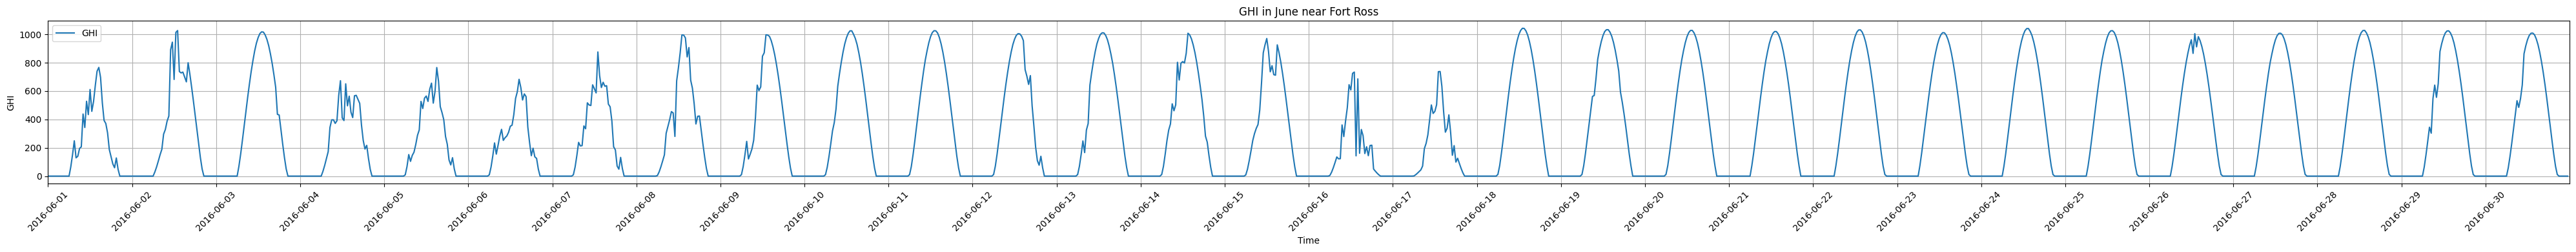

In [62]:
plt.figure(figsize=(40, 4))

# day_time_index_utc = day_time_index.tz_convert('UTC')
# plt.plot(day_time_index_utc, day_tseries, label="GHI")
plt.plot(time_series_for_month, ghi_values_for_month, label="GHI")

plt.gca().xaxis.set_major_locator(mdates.DayLocator(tz=SITE_TIMEZONE))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d', tz=SITE_TIMEZONE))
plt.xlim(start_of_month, end_of_month)

plt.title(f"GHI in {start_of_month.month_name()} near Fort Ross")
plt.xlabel("Time")
plt.ylabel("GHI")

plt.xticks(rotation=45)

plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## Get Tide Data

In [63]:
# Define the API parameters
params = {
    'product': 'predictions',
    'application': 'NOS.COOPS.TAC.WL',
    'begin_date': '20160531',
    'end_date': '20160701',
    'datum': 'MLLW', # is this reasonable? https://tidesandcurrents.noaa.gov/datum_options.html
    'station': '9416024',  # Fort Ross station ID
    'time_zone': 'lst_ldt',
    'units': 'english',
    'interval': 'hilo',
    'format': 'json'
}

url = 'https://api.tidesandcurrents.noaa.gov/api/prod/datagetter'
tide_api_response = requests.get(url, params=params)

if tide_api_response.status_code == 200:
    tide_df = pd.DataFrame(tide_api_response.json()['predictions'])
    tide_df['t'] = pd.to_datetime(tide_df['t']).dt.tz_localize(SITE_TIMEZONE)
    tide_df['v'] = pd.to_numeric(tide_df['v'])
else:
    print("Failed to retrieve data:", tide_api_response.status_code)


### Interpolate Tide Data

In [64]:
# Convert timestamps to a numeric format for interpolation
timestamps_numeric = mdates.date2num(tide_df['t'])
interpolator = interp1d(timestamps_numeric, tide_df['v'], kind='cubic', fill_value="extrapolate")

# Create a high-resolution time series across the month for plotting the interpolation
interpolation_granularity = ghi_values_for_month.shape[0]
time_series_high_res_numeric = np.linspace(timestamps_numeric.min(), timestamps_numeric.max(), interpolation_granularity)
tide_interpolated = interpolator(time_series_high_res_numeric)
time_series_high_res = mdates.num2date(time_series_high_res_numeric)

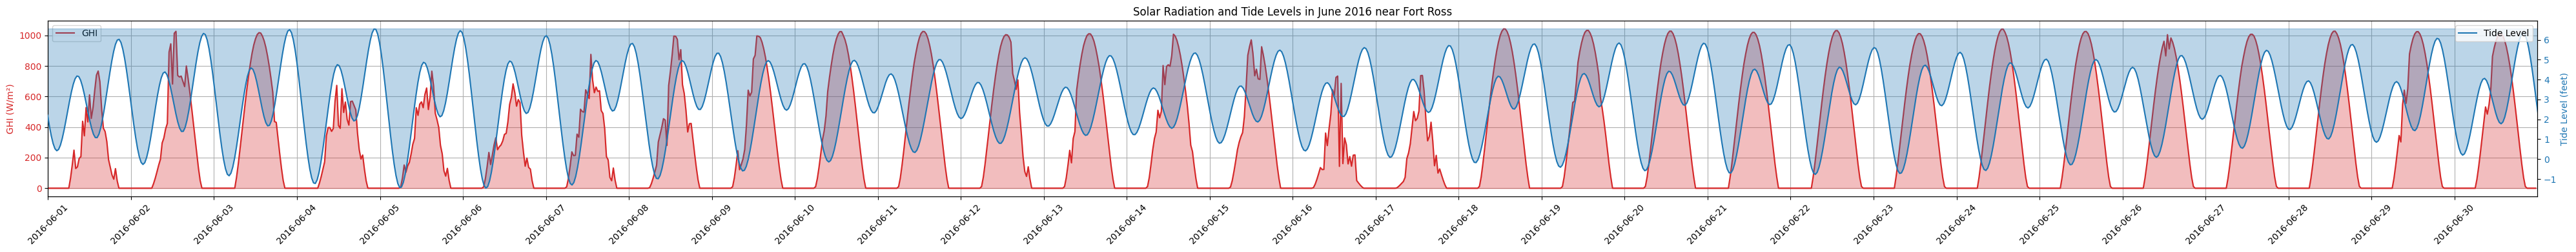

In [65]:
fig, ax1 = plt.subplots(figsize=(40, 4))

# Plot GHI data
ax1.plot(time_series_for_month, ghi_values_for_month, label="GHI", color='tab:red', zorder=3)
ax1.xaxis.set_major_locator(mdates.DayLocator(tz=SITE_TIMEZONE))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d', tz=SITE_TIMEZONE))
ax1.set_xlim(start_of_month, end_of_month)
ax1.tick_params(axis='x', rotation=45)
ax1.set_ylabel('GHI (W/m²)', color='tab:red')
ax1.tick_params(axis='y', labelcolor='tab:red')

# Shade the area above the GHI line
ax1.fill_between(time_series_for_month, ghi_values_for_month.min(), ghi_values_for_month, color='tab:red', alpha=0.3, zorder=2)

# Create a secondary y-axis for tide data
ax2 = ax1.twinx()
ax2.plot(time_series_high_res, tide_interpolated, label='Tide Level', color='tab:blue', linestyle='-', zorder=4)
ax2.set_ylabel('Tide Level (feet)', color='tab:blue')
ax2.tick_params(axis='y', labelcolor='tab:blue')

# Shade the area below the tide line
ax2.fill_between(time_series_high_res, tide_interpolated, tide_interpolated.max(), color='tab:blue', alpha=0.3, zorder=1)

# Title, grid, and legend
ax1.set_title(f"Solar Radiation and Tide Levels in {start_of_month.strftime('%B %Y')} near Fort Ross")
ax1.grid(True)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

fig.tight_layout()
plt.show()


### Normalize and Invert Tide Data
We want to scale the solar radiation according to how low the tide was, so with our tide data currently in the range 0-1 where 0 is the lowest tide, we need to invert that so 0 is the highest tide, meaning the least solar radiation is getting absorbed.

In [66]:
min_val = tide_interpolated.min()
max_val = tide_interpolated.max()
tide_values_inverted = 1 - (tide_interpolated - min_val) / (max_val - min_val)

In [67]:
tide_values_inverted.shape

(1440,)

In [69]:
ghi_values_for_month.shape

(1440,)

In [72]:
tide_scaled_ghi = tide_values_inverted * ghi_values_for_month

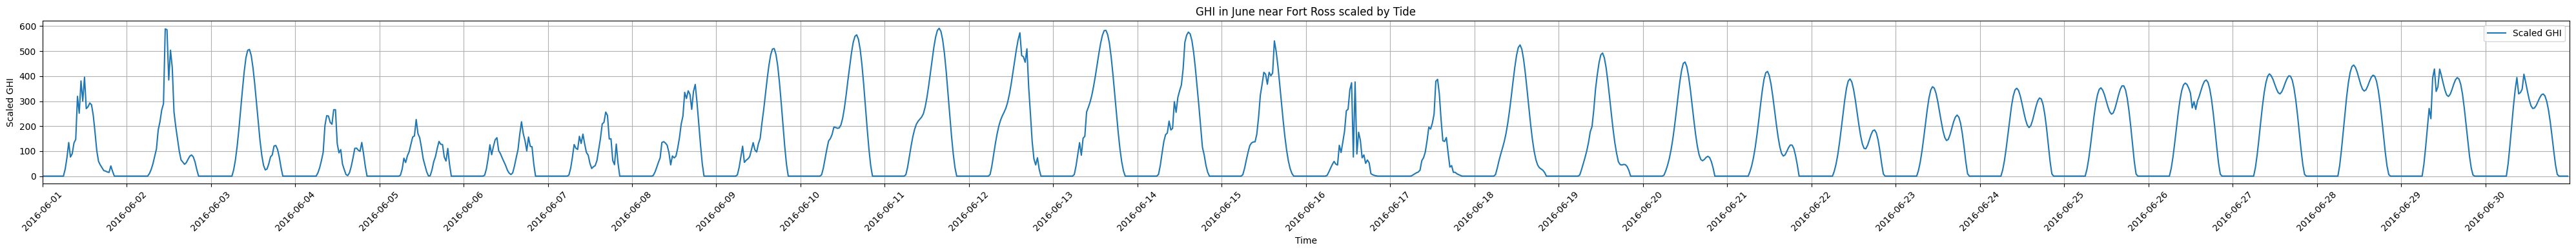

In [73]:
plt.figure(figsize=(40, 4))

# day_time_index_utc = day_time_index.tz_convert('UTC')
# plt.plot(day_time_index_utc, day_tseries, label="GHI")
plt.plot(time_series_for_month, tide_scaled_ghi, label="Scaled GHI")

plt.gca().xaxis.set_major_locator(mdates.DayLocator(tz=SITE_TIMEZONE))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d', tz=SITE_TIMEZONE))
plt.xlim(start_of_month, end_of_month)

plt.title(f"GHI in {start_of_month.month_name()} near Fort Ross scaled by Tide")
plt.xlabel("Time")
plt.ylabel("Scaled GHI")

plt.xticks(rotation=45)

plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()